# Durable Consumption Model

In [7]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass
from consav import linear_interp
from consav.grids import nonlinspace # grids

import numba as nb
nb.set_num_threads(8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# NEGM - nested endogenous grid method

Define the **post-decision marginal value of cash:**

$$
\begin{aligned}
q_{t}(p_{t},d_{t},a_{t})&=\beta R\mathbb{E}_{t}[u_{c}(c_{t+1},d_{t+1})]\\
&=&\beta R\mathbb{E}_{t}[\alpha c_{t+1}^{\alpha(1-\rho)-1}d_{t+1}^{(1-\alpha)(1-\rho)}]
\end{aligned}
$$

Note that all optimal interior consumption choices must satisfy the **Euler-equation**

$$
\begin{aligned}
u_{c}(c_{t},d_{t})=\alpha c_{t}^{\alpha(1-\rho)-1}d_{t}^{(1-\alpha)(1-\rho)}&=q(p_{t},d_{t},a_{t})
\end{aligned}
$$

This implies that we have an analytical mapping from the post-decision space $(p_t,d_t,a_t)$ to consumption and cash-on-hand $(c_t,m_t)$:

$$
\begin{aligned}
c_{t} &=\frac{1}{\alpha}\left(\frac{q(a_{t},d_{t},p_{t})}{d_{t}^{(1-\alpha)(1-\rho)}}\right)^{\alpha(1-\rho)-1}
\\
m_{t} &= a_{t}+c_{t}
\end{aligned}
$$

**NEGM** uses this mapping (and an upperenvelope algorithm) to solve the keeper problem much faster.

In [9]:
model_negm = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','do_print':False})
model_negm.precompile_numba() # solve with very coarse grids
model_negm.solve()
model_negm.simulate()

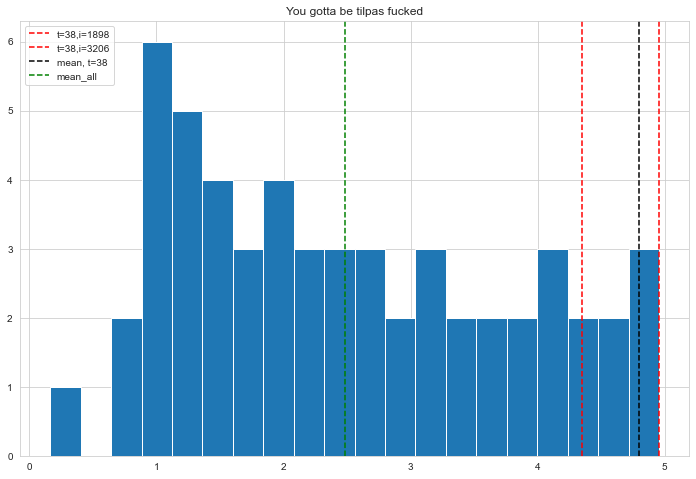

In [10]:
plt.figure(figsize=(12,8))
plt.title('You gotta be tilpas fucked')
plt.hist((np.mean(model_negm.sim.m,axis=1)), bins=20);
plt.axvline(model_negm.sim.m[38,1898],color='r',linestyle='--',label='t=38,i=1898')
plt.axvline(model_negm.sim.m[38,3206],color='r',linestyle='--',label='t=38,i=3206')
plt.axvline(np.mean(model_negm.sim.m,axis=1)[38],color='k',linestyle='--',label='mean, t=38')
plt.axvline(np.mean(model_negm.sim.m),color='g',linestyle='--',label='mean_all')
plt.legend()
plt.show();

**Plot** interactive decision functions:

In [11]:
model_negm.decision_functions()

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

**Plot** life-cycle profiles:

In [16]:
(np.maximum(model_negm.sim.mpc,0.0)).min()

0.0

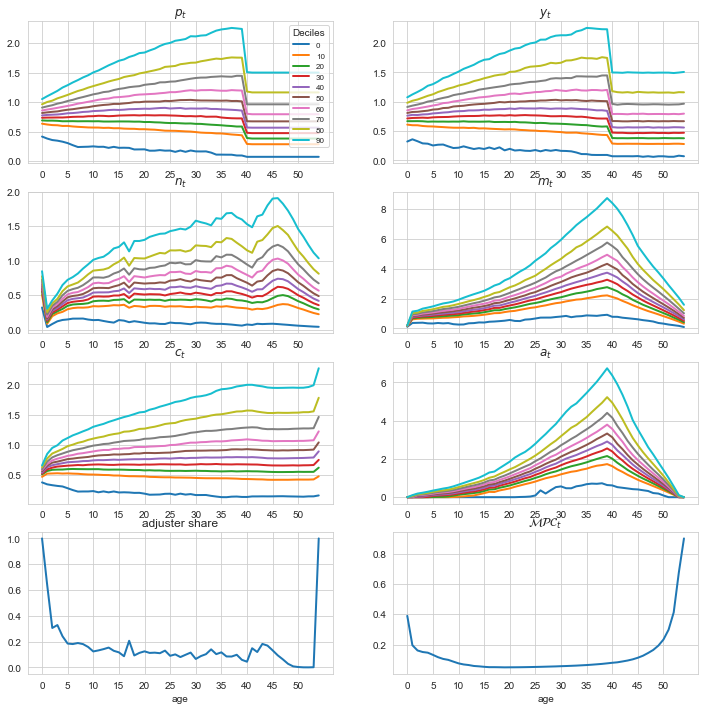

In [17]:
model_negm.lifecycle(deciles=True)

In [ ]:
model_negm.mpc_over_cash_on_hand()

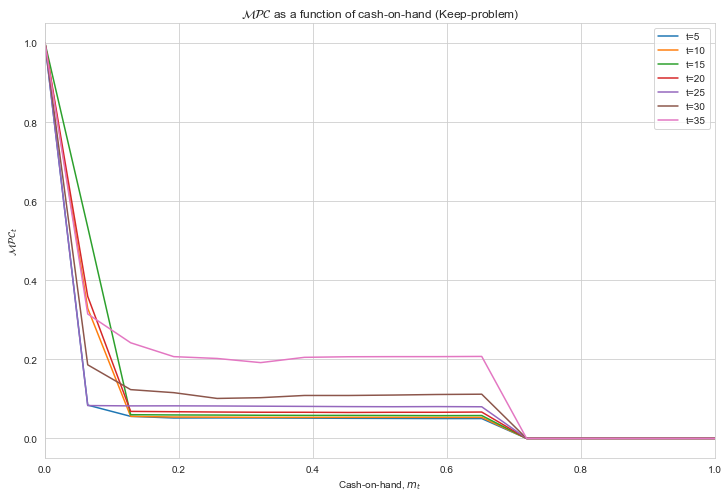

In [45]:
# plot mpc as a function of cash-on-hand for given t
p_bar = np.mean(model_negm.sim.p,axis=1)
n_bar = np.mean(model_negm.sim.n,axis=1)

c0 = np.zeros(shape=(model_negm.par.T, len(model_negm.par.grid_m)))
c1 = np.zeros(shape=(model_negm.par.T, len(model_negm.par.grid_m)))
mpc = np.zeros(shape=(model_negm.par.T, len(model_negm.par.grid_m)))

m_grid =  nonlinspace(0,model_negm.par.m_max,model_negm.par.Nm,1.1) # model_negm.par.grid_m

for t in range(model_negm.par.T):
    t = int(t)    
    for m in m_grid:
        m = int(m)
        c0[t,m] = linear_interp.interp_3d(
                model_negm.par.grid_p,model_negm.par.grid_n,model_negm.par.grid_m,model_negm.sol.c_keep[t],
                p_bar[t],n_bar[t],m)
        c1[t,m] = linear_interp.interp_3d(
                model_negm.par.grid_p,model_negm.par.grid_n,model_negm.par.grid_m,model_negm.sol.c_keep[t],
                p_bar[t],n_bar[t],m+model_negm.par.mpc_eps)
        mpc[t,m] = (c1[t,m]-c0[t,m])/model_negm.par.mpc_eps

plt.figure(figsize=(12,8))
for t in np.arange(5,model_negm.par.T,5):
    plt.plot(model_negm.par.grid_m,mpc[t,:],label='t={}'.format(t))
plt.xlim(0,1)
plt.xlabel('Cash-on-hand, $m_t$')
plt.ylabel('$\mathcal{MPC}_t$')
plt.title('$\mathcal{MPC}$ as a function of cash-on-hand (Keep-problem)')
plt.legend()
plt.show()

# NVFI - nested value function iteration

Define the **post-decision value function** as

$$ w_{t}(p_{t},n_{t},a_{t}) = \beta \mathbb{E}_{t}[v_{t+1}(m_{t+1},n_{t+1},p_{t+1})] $$

The **keeper problem** can then be written:

$$
\begin{aligned}
v_{t}^{keep}(p_{t},n_{t},m_{t})&=\max_{c_{t}}u(c_{t},n_{t})+ w_{t}(p_{t},n_{t},a_{t})]\\&\text{s.t.}&\\a_{t}&=&m_{t}-c_{t}\geq0
\end{aligned}
$$

The **adjuster problem** can further be written:

$$
\begin{aligned}
v_{t}^{adj.}(x_{t})&=\max_{d_{t}}v_{t}^{keep}(p_{t},d_{t},n_{t})\\&\text{s.t.}&\\m_{t}&=&x_{t}-d_{t}
\end{aligned}
$$

**NVFI** solves this reformulated problem.

In [18]:
model_nvfi = DurableConsumptionModelClass(name='example_nvfi',par={'solmethod':'nvfi','do_print':True})
model_nvfi.precompile_numba() # solve with very coarse grids
model_nvfi.solve()
model_nvfi.simulate()

numba precompiled in 14.3 secs
 t = 34 solved in 0.1 secs
  w computed in 4.5 secs
  solved keeper problem in 1.3 secs
  solved adjuster problem in 0.0 secs
 t = 33 solved in 5.9 secs
  w computed in 4.6 secs
  solved keeper problem in 1.3 secs
  solved adjuster problem in 0.0 secs
 t = 32 solved in 11.8 secs
  w computed in 4.5 secs
  solved keeper problem in 1.4 secs
  solved adjuster problem in 0.0 secs
 t = 31 solved in 17.7 secs
  w computed in 4.6 secs
  solved keeper problem in 1.3 secs
  solved adjuster problem in 0.0 secs
 t = 30 solved in 23.6 secs
  w computed in 4.6 secs
  solved keeper problem in 1.3 secs
  solved adjuster problem in 0.0 secs
 t = 29 solved in 29.5 secs
  w computed in 4.5 secs
  solved keeper problem in 1.3 secs
  solved adjuster problem in 0.0 secs
 t = 28 solved in 35.3 secs
  w computed in 4.5 secs
  solved keeper problem in 1.3 secs
  solved adjuster problem in 0.0 secs
 t = 27 solved in 41.2 secs
  w computed in 4.5 secs
  solved keeper problem in 1.

**Plot** interactive decision functions:

In [19]:
model_nvfi.decision_functions()

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

**Plot** life-cycle profiles:

In [32]:
model_nvfi.lifecycle(deciles=True)

NameError: name 'model_nvfi' is not defined

# Compare life-cycles from NVFI and NEGM

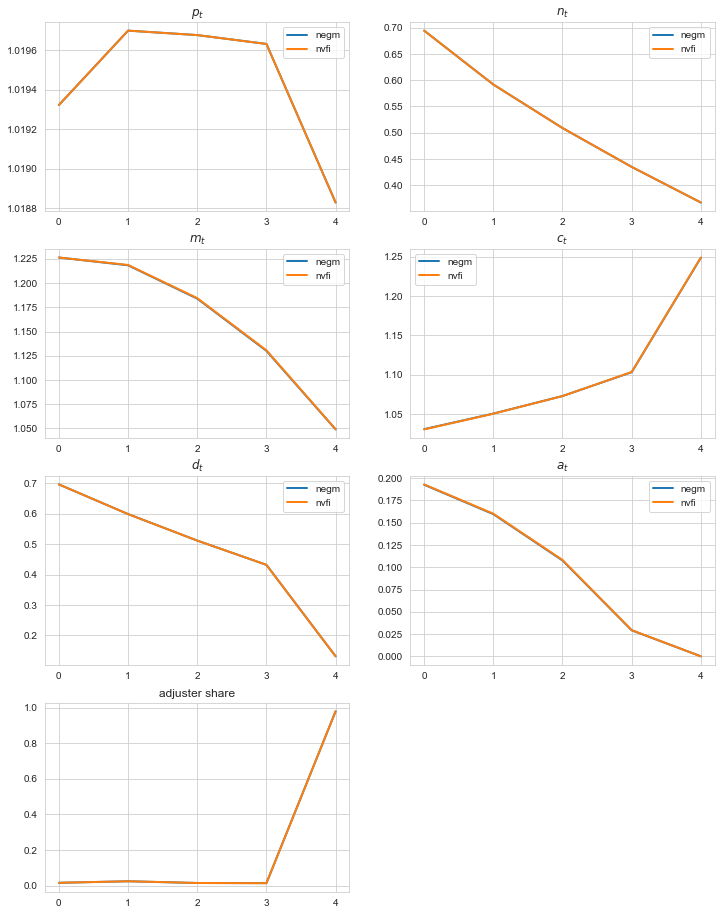

In [11]:
from figs import lifecycle_compare
lifecycle_compare(model_negm,'negm',model_nvfi,'nvfi')

# Compare life-cycle profiles with VFI

In [12]:
model_vfi = DurableConsumptionModelClass(name='example_vfi',par={'solmethod':'vfi','T':T,'do_print':True})
model_vfi.precompile_numba() # solve with very coarse grids
model_vfi.solve()
model_vfi.simulate()
model_vfi.save()

Traceback (most recent call last):
  File "/Users/frederikp/OneDrive - University of Copenhagen/Kandidat/Dynamic Programming/dp2022/ConsumptionSavingCleaned/DurableConsumptionModel.py", line 307, in solve
    post_decision.compute_wq(t,sol,par,compute_q=True)
  File "/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/numba/core/dispatcher.py", line 434, in _compile_for_args
    return_val = self.compile(tuple(argtypes))
  File "/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/numba/core/dispatcher.py", line 979, in compile
    cres = self._compiler.compile(args, return_type)
  File "/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/numba/core/dispatcher.py", line 141, in compile
    status, retval = self._compile_cached(args, return_type)
  File "/Users/frederikp/opt/anaconda3/lib/python3.8/site-packages/numba/core/dispatcher.py", line 155, in _compile_cached
    retval = self._compile_core(args, return_type)
  File "/Users/frederikp/opt/anaconda3/lib/python3

KeyboardInterrupt: 

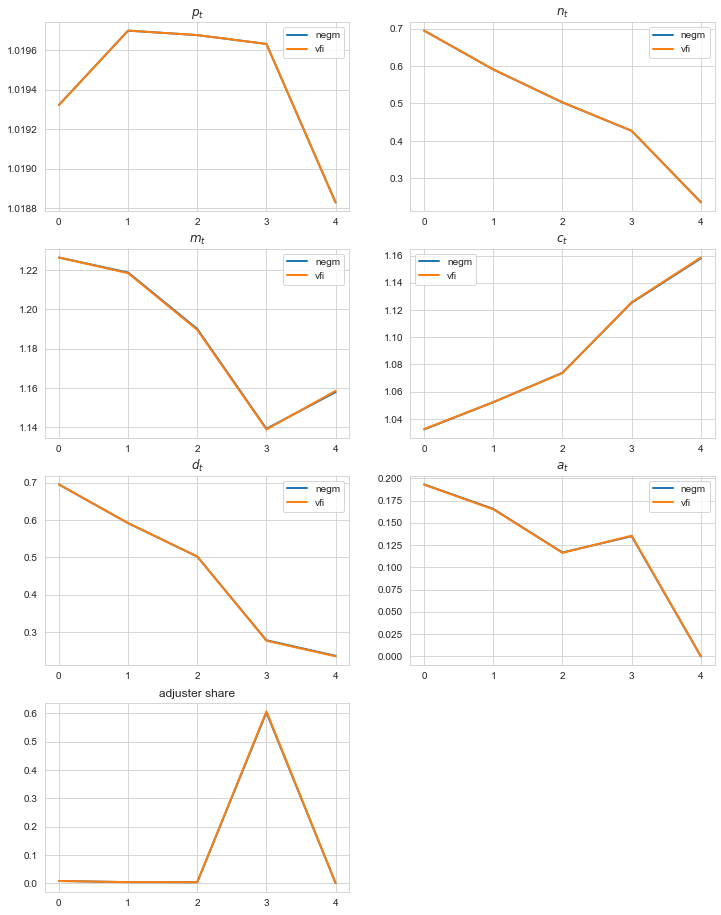

In [ ]:
lifecycle_compare(model_negm,'negm',model_vfi,'vfi')